In [173]:
#cell code 1
import os
import logging
from typing import List, Literal, Optional
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_neo4j.vectorstores.neo4j_vector import Neo4jVector
from langchain_neo4j.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_neo4j import Neo4jGraph
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from langchain_neo4j.chains.graph_qa.cypher import GraphCypherQAChain
from langchain_huggingface import HuggingFaceEmbeddings
from IPython.display import Image, display
from langgraph.graph import StateGraph, END, add_messages
from typing_extensions import TypedDict, Annotated


In [174]:
#cell code 2

# --- Environment Variables ---
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

# Neo4J Local
neo4j_uri = os.environ.get("NEO4J_AURA")
neo4j_username = os.environ.get("NEO4J_AURA_USERNAME")
neo4j_password = os.environ.get("NEO4J_AURA_PASSWORD")

#Langchain
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-Agent CyKG" 
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY", "")
os.environ["LANGCHAIN_ENDPOINT"] = os.environ.get("LANGCHAIN_ENDPOINT", "")

# --- Logging Config ---
logging.basicConfig(
     level=logging.INFO,
     format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
     handlers=[
         logging.FileHandler('./log/multi_agent_cykg.log'),
         logging.StreamHandler()
     ]
)
logger = logging.getLogger(__name__)

In [175]:
#cell code 3
# --- LLM and Graph Connections ---
graph = Neo4jGraph(
    url=neo4j_uri,
    username=neo4j_username,
    password=neo4j_password
)
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

# --- Global Configs & Schema ---
DEFAULT_MAX_ITERATIONS = 3
NEO4J_SCHEMA_RAW = graph.schema
NEO4J_SCHEMA_ESCAPED_FOR_PROMPT = NEO4J_SCHEMA_RAW.replace("{", "{{").replace("}", "}}")

VECTOR_INDEX_NAME = "vector"
KEYWORD_INDEX_NAME = "keyword"

# --- Embeddings Model ---
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

2025-07-30 18:45:55,090 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-07-30 18:45:55,091 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


In [176]:
#cell code 4
class AgentState(TypedDict):
    question: str
    original_question: str
    is_relevant: bool
    is_log_question: bool
    
    log_vector_context: Optional[str]
    latest_vector_context: Optional[List[dict]]
    log_cypher_context: Optional[List[dict]]
    latest_cypher_context: Optional[List[dict]]
    
    generated_question_for_rdf: Optional[str]
    rdf_context: Optional[str]
    
    answer: Optional[str]
    cypher_query: Optional[str]
    error: Optional[str]
    messages: Annotated[list, add_messages]
    
    # reflection state
    cypher_iteration_count: int
    vector_iteration_count: int
    vector_answer_sufficient: bool 
    cypher_answer_sufficient: bool 
    
    max_iterations: int

In [177]:
#cell code 5

# --- Tools & Chains for Guardrails ---
class GuardrailsOutput(BaseModel):
    decision: Literal["relevant", "irrelevant"] = Field(description="Checks if the question is relevant to cybersecurity topics within the knowledge graph, including log analysis, malware, and threat actors.")

guardrails_prompt = ChatPromptTemplate.from_messages([
    (
        "system", 
        """
        You are a gatekeeper for a Q&A system that queries a knowledge graph.
        Your task is to determine if a question is answerable by the graph.
        The graph contains two types of information:
            1.  **Log Data:** Detailed records of system events, including specific users, servers, hosts, processes, and session activities (e.g., login successes or failures).
            2.  **Cybersecurity Knowledge:** General concepts like malware, threat actors, and attack frameworks (e.g., MITRE ATT&CK).

        A question is **relevant** if it asks about specific entities found in logs (like 'user danette', 'server-db-01') OR general cybersecurity topics.
        A question is **irrelevant** if it is completely off-topic (e.g., 'what is the weather?', 'tell me a joke').

        Only allow relevant questions to pass.
        """
    ),
    ("human", "Question: {question}"),
])
guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)

# --- Node Definition: Guardrails ---
def guardrails_node(state: AgentState):
    """Decides if the question is relevant."""
    logger.info("--- Executing Node: [[Guardrails]] ---")
    question = state['question']
    result = guardrails_chain.invoke({"question": question})
    if result.decision == "irrelevant":
        logger.warning(f"[[Guardrails]]: Irrelevant question detected -> '{question}'")
        return {"is_relevant": False, "answer": "Sorry, I can only answer questions related to cybersecurity, such as log analysis, attack techniques, malware, and threat actors."}
    else:
        logger.info("[[Guardrails]]: Question is relevant.")
        return {"is_relevant": True}

In [178]:
# cell code 6

# --- Tools & Chains for Routing ---
class RouteQuery(BaseModel):
    """ 
    Routes the user's question to the appropriate tool
    """
    datasource: Literal["log_analysis", "cyber_knowledge"] = Field(
        description="Given the user question, route it to the 'log_analysis' tool if it is about specific log events, users, or system activities, or to 'cyber_knowledge' if it is a general cybersecurity question."
    )
    
router_prompt = ChatPromptTemplate.from_messages([
    (
        
        "system",
        """You are an expert at routing a user's question to the appropriate data source.

        Follow these rules:
        1.  **Prioritize Log Analysis**: If the question contains a specific entity name (like a username 'daryl', a server name, an IP address, or a specific process), ALWAYS route it to 'log_analysis'.
        2.  **Use Cyber Knowledge for General Queries**: If the question is about a general concept, tactic, or threat (e.g., "What is brute force?"), route it to 'cyber_knowledge'.
        
        """
    ),
    (
        "human", 
        "Question: {question}"
    ),
])

router_chain = router_prompt | llm.with_structured_output(RouteQuery)

# --- Node Definition: Router ---
def log_or_cyber_router_node(state: AgentState):
    """
    Determines if the question is about logs or general cyber knowledge
    """
    logger.info("--- Executing Node: [[Router]] ---")
    question = state['question']
    result = router_chain.invoke({"question": question})
    logger.info(f"[[Router]]: Routing decision: {result.datasource}")
    if result.datasource == "log_analysis":
        return {"is_log_question": True}
    else:
        return {"is_log_question": False}

In [179]:
#cell code 7

# --- Vector Index Initialization ---
vector_index = Neo4jVector.from_existing_index(
    embedding=embeddings,
    url=neo4j_uri,
    username=neo4j_username,
    password=neo4j_password,
    index_name=VECTOR_INDEX_NAME,
    keyword_index_name=KEYWORD_INDEX_NAME,
    search_type="hybrid"
)

d:\Project\multi-agents-rag-cykg\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [180]:
#cell code 8

# --- Chains for Vector Search (Entity Extraction) ---
class LogEntities(BaseModel):
    """Identifies information about resources in the log."""

    entity_values: List[str] = Field(
        ...,
        description="All entities such as User, Server, Service, Host, "
        "System, Software, Device, Process, Machine, Session, or Document file names that appear in the text.",
    )
    
entity_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert at extracting entities from text related to system logs. "
            "Extract the name or ID of entities such as User, Server, Service, "
            "Host, System, Software, Device, Process, Machine, Session, and the filename of the Document.",
        ),
        (
            "human",
            "Use the given format to extract information from"
            "the following input: {question}",
        ),
    ]
)

entity_chain = entity_prompt | llm.with_structured_output(LogEntities)

In [181]:
#cell code 9

# --- Helper Functions for Vector Search ---
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of resources mentioned
    in the question
    """
    result = ""
    
    entities = entity_chain.invoke({"question": question})
    print(f"\n--- Extracted Entities: {entities.entity_values} ---")

    for entity_value in entities.entity_values:
        query = generate_full_text_query(entity_value)
        if not query:
            continue
        
        response = graph.query(
            """
            CALL db.index.fulltext.queryNodes('log_entities', $query, {limit: 10})
            YIELD node AS entity
            
            MATCH (chunk:Chunk)-[:HAS_ENTITY]->(entity)
            
            OPTIONAL MATCH (chunk)-[:PART_OF]->(doc:Document)
            
            WITH entity, chunk, doc,
                 CASE WHEN 'Document' IN labels(entity) 
                      THEN entity.fileName 
                      ELSE entity.id 
                 END AS entity_name
                 
            RETURN "Entity '" + entity_name + "' found in document '" + coalesce(doc.fileName, 'N/A') +
                   "'. The context of the text is: '" + left(chunk.text, 250) + "...'"
                   AS output
            LIMIT 10
            """,
            {"query": query},
        )
        if response:
            result += "\n".join([el['output'] for el in response])
    return result

def query_vector_search(question: str):
    """
    Query the graph and vector index using a vector approach for vector similarity search.
    This is for questions that require finding similar concepts or descriptions.
    """
    print(f"--- Executing Vector Search for: {question} ---")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
    {structured_data}
    Unstructured data:
    {"#Resource ". join(unstructured_data)}
    """
    return final_data


# --- Node Definition: Vector Agent ---
def vector_search_node(state: AgentState):
    """Calls the vector search tool and populates the state."""
    logger.info("--- Executing Node: [[vector_agent]] ---")
    question = state['question']
    try:
        vector_context = query_vector_search(question)
        logger.info("[[Vector Agent]] : Vector search completed successfully.")
        logger.info(f"[[Vector Agent]] : Vector search context found:\n{vector_context}")
        return {"log_vector_context": vector_context}
    except Exception as e:
        logger.error(f"[[Vector Agent]] : Vector search failed: {e}")
        return {"log_vector_context": f"Error during vector search: {e}"}

In [182]:
#cell code 10

# --- Tools & Chains for Reviewing Answers ---
class ReviewOutput(BaseModel):
    """Decision model for reviewing the sufficiency of an answer."""
    decision: Literal["sufficient", "insufficient"] = Field(description="Is the provided context sufficient to answer the user's question?")
    reasoning: str = Field(description="A brief explanation for the decision.")

review_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert in evaluating retrieved information. Your task is to determine if the provided 'Context' contains concrete, factual information that helps to answer the 'Original Question'. The context is 'sufficient' if it provides at least one factual data point relevant to the question, even if it's not a complete answer. It is 'insufficient' only if it's completely empty or irrelevant."),
    ("human", "Original Question: {question}\\n\\nContext:\\n{context}\\n\\nBased on this definition, is the context sufficient?"),
])
review_chain = review_prompt | llm.with_structured_output(ReviewOutput)

# --- Node Definition: Review Vector Answer ---
def review_vector_node(state: AgentState):
    """Reviews the context from the vector search."""
    logger.info("--- Executing Node: [[review_vector_answer]] ---")
    question = state['original_question']
    context = state['log_vector_context']
    
    if context and "Error during vector search" not in context:
        logger.info(f"[[Review Vector]]: Found new context, saving as 'latest_vector_context'.")
        state['latest_vector_context'] = context
    
    if not context or "Error during vector search" in context:
        logger.warning("[[Review Vector]]: Context is empty or contains an error. Marking as insufficient.")
        return {"vector_answer_sufficient": False, "log_vector_context": None}

    review = review_chain.invoke({"question": question, "context": context})
    logger.info(f"[[Review Vector]]: Decision: {review.decision}. Reasoning: {review.reasoning}")
    
    return {"vector_answer_sufficient": review.decision == "sufficient"}

# --- Node Definition: Review Cypher Answer ---
def review_cypher_node(state: AgentState):
    """Reviews the context from the cypher search."""
    logger.info("--- Executing Node: [[review_cypher_answer]] ---")
    question = state['original_question']
    context = str(state['log_cypher_context'])
    
    if context and context is not None:
        logger.info(f"[[Review Cypher]]: Found new context, saving as 'latest_cypher_context'.")
        state['latest_cypher_context'] = context

    if not context:
        logger.warning("[[Review Cypher]]: Context is empty. Marking as insufficient.")
        return {"cypher_answer_sufficient": False, "log_cypher_context": None}
        
    review = review_chain.invoke({"question": question, "context": context})
    logger.info(f"[[Review Cypher]]: Decision: {review.decision}. Reasoning: {review.reasoning}")

    return {"cypher_answer_sufficient": review.decision == "sufficient"}

In [183]:
#cell code 11

# --- Cypher Generation Prompt Template ---
cypher_generation_template = """
You are an expert Neo4j Cypher translator who converts English to Cypher based on the Neo4j Schema provided, following the instructions below:
        1. Generate Cypher query compatible ONLY for Neo4j Version 5.
        2. Do not use EXISTS, SIZE, HAVING keywords in the cypher. Use an alias when using the WITH keyword.
        3. Use only Node labels and Relationship types mentioned in the schema.
        4. Do not use relationships that are not mentioned in the given schema.
        5. For property searches, use case-insensitive matching. E.g., to search for a User, use `toLower(u.id) CONTAINS 'search_term'`.
        6. Assign a meaningful alias to every node and relationship in the MATCH clause (e.g., `MATCH (u:User)-[r:FAILED_LOGIN]->(s:System)`).
        7. In the RETURN clause, include only the components (nodes, relationships, or properties) needed to answer the question.
        8. To count distinct items from an `OPTIONAL MATCH`, collect them first and then use `size()` on the list to avoid null value warnings (e.g., `WITH main, collect(DISTINCT opt) AS items RETURN size(items) AS itemCount`).
        9. To create unique pairs of nodes for comparison, use `WHERE elementId(node1) < elementId(node2)`.
        10. **CRITICAL RULE**: When returning the `type()` of a relationship, you MUST give the relationship a variable in the `MATCH` clause. E.g., `MATCH (u:User)-[r:HAS_SESSION]->(s:Server) RETURN type(r)`. Do NOT use `type()` on a relationship without a variable.

Schema:
{schema}

Note: 
Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything other than for you to construct a Cypher statement.
Do not run any queries that would add to or delete from the database.

Examples:

1.  Question: Which users have the most authentication failures?
    Query:
    MATCH (u:User)-[:AUTHENTICATION_FAILURE_ON]->()
    RETURN u.id AS userId, count(*) AS failureCount
    ORDER BY failureCount DESC
    LIMIT 10

2.  Question: List devices where users opened or closed a session.
    Query:
    MATCH (u:User)-[r:SESSION_OPENED_ON|SESSION_CLOSED_ON]->(device)
    RETURN u.id AS userId, type(r) AS action, labels(device) AS deviceType, device.id AS deviceId
    LIMIT 20

3.  Question: Tell the full path of the session: from the device where it was opened to where it was closed by root user
    Query:
    MATCH (u:User {{id: "root"}})-[open:SESSION_OPENED_ON]->(startDevice),(u)-[close:SESSION_CLOSED_ON]->(endDevice)
    RETURN
        u.id             AS userId,
        type(open)      AS openedOnRel,
        labels(startDevice) AS startDeviceType,
        startDevice.id  AS startDeviceId,
        type(close)     AS closedOnRel,
        labels(endDevice)   AS endDeviceType,
        endDevice.id    AS endDeviceId
        
4.  Question: Give me information about daryl's activity?
    Query:
    MATCH (u:User)-[r]->(n)
    WHERE toLower(u.id) = 'daryl'
    RETURN u.id AS user, type(r) as relationship, n.id as entity


The question is:
{question}
"""

cyper_generation_prompt = PromptTemplate(
    template=cypher_generation_template,
    input_variables=["schema","question"]
)

In [184]:
#cell code 12

# --- Cypher QA Prompt Template ---
qa_template = """
You are an assistant that takes the results from a Neo4j Cypher query and forms a human-readable response. The query results section contains the results of a Cypher query that was generated based on a user's natural language question. The provided information is authoritative; you must never question it or use your internal knowledge to alter it. Make the answer sound like a response to the question.
Final answer should be easily readable and structured.
Query Results:
{context}

Question: {question}
If the provided information is empty, respond by stating that you don't know the answer. Empty information is indicated by: []
If the information is not empty, you must provide an answer using the results. If the question involves a time duration, assume the query results are in units of days unless specified otherwise.
Never state that you lack sufficient information if data is present in the query results. Always utilize the data provided.
Helpful Answer:
"""

qa_generation_prompt = PromptTemplate(
    template=qa_template,
    input_variables=["context", "question"]
)

In [185]:
#cell code 13

# --- Cypher QA Chain and Query Function ---
cypher_qa_chain = GraphCypherQAChain.from_llm(
    top_k=10,
    graph=graph,
    verbose=True,
    validate_cypher=True,
    return_intermediate_steps=True,
    cypher_prompt=cyper_generation_prompt,
    qa_prompt=qa_generation_prompt,
    qa_llm=ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
    cypher_llm=ChatOpenAI(model="gpt-4o", temperature=0),
    allow_dangerous_requests=True,
    use_function_response=True
)

def query_cypher(question: str) -> dict:
    """
    Generate and run a Cypher query against the graph database.
    Use this for complex questions requiring structured data, aggregations, or specific graph traversals
    Returns the query and the result context.
    """
    print(f"--- Executing Cypher Search for: {question} ---")
    response = cypher_qa_chain.invoke({"query": question})
    return {
        "query": response["intermediate_steps"][0]["query"],
        "context": response["intermediate_steps"][1]["context"]
    }

# --- Node Definition: Cypher Agent ---
def cypher_query_node(state: AgentState):
    """Calls the cypher search tool and populates the state."""
    logger.info(f"--- Executing Node: [[cypher_agent]] (Attempt: {state.get('iteration_count', 1)}) ---")
    question = state['question']
    try:
        cypher_result = query_cypher(question)
        context = cypher_result.get("context", [])
        generated_query = cypher_result.get("query", "")

        if not context:
            logger.warning(f"[[Cypher Agent]]: No results found for query: {generated_query}")
        else:
            logger.info(f"[[Cypher Agent]]: Found context. Query: {generated_query}")

        return {
            "cypher_query": generated_query,
            "log_cypher_context": context
        }
    except Exception as e:
        logger.error(f"[[Cypher Agent]] failed: {e}", exc_info=True)
        return {
            "error": f"Query Cypher failed: {e}",
            "log_cypher_context": [],
            "cypher_query": "Failed to generate Cypher query due to an error."
        }

In [186]:
#cell code 14

# --- Chains for Cypher Reflection ---
class RephrasedQuestion(BaseModel):
    rephrased_question: str = Field(description="A rephrased, more specific version of the original question to improve Cypher query generation.")

cypher_reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system", 
        f"""
        You are a query correction expert. A Cypher query returned no results.
        Your task is to rephrase the user's question to be more specific and likely to succeed with the given Neo4j graph schema.
        Analyze the failed query and the schema. For example, if the question was too broad, make it more specific. If it used terms not in the schema, suggest alternatives.
        Do not just repeat the question. Provide a meaningful improvement.
        
        Schema:
        {NEO4J_SCHEMA_ESCAPED_FOR_PROMPT}
        """
    ),
    (
        "human", 
        "Original Question: {original_question}\n\nFailed Cypher Query:\n{cypher_query}\n\nRephrase the question to improve the chances of getting a result."
    ),
])
reflection_chain = cypher_reflection_prompt | llm.with_structured_output(RephrasedQuestion)

# --- Node Definition: Cypher Reflection ---
def cypher_reflection_node(state: AgentState):
    """Reflects on the failed cypher query and rephrases the question."""
    logger.info("--- Executing Node: [[cypher_reflection]] ---") 
    original_question = state['original_question']
    failed_query = state['cypher_query']
    
    rephrased_result = reflection_chain.invoke({
        "original_question": original_question,
        "cypher_query": failed_query
    })
    
    new_question = rephrased_result.rephrased_question
    iteration_count = state['cypher_iteration_count'] + 1
    logger.info(f"[[Cypher Reflection]]: Rephrasing question to: '{new_question}'. New attempt: {iteration_count}.")
    
    return {"question": new_question, "cypher_iteration_count": iteration_count}

In [187]:
#cell code 15

# --- Tools & Chains for Vector Reflection ---
class RephrasedQuestion(BaseModel):
    rephrased_question: str = Field(description="A rephrased, more specific version of the original question to improve search results.")

vector_reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """
        You are a query correction expert. A vector search returned insufficient or irrelevant context.
        Your task is to rephrase the user's question to be more specific and likely to succeed with a vector/keyword search.
        Analyze the original question and the insufficient context. For example, if the question was too broad, suggest adding specific keywords. If it used ambiguous terms, make them clearer.
        Do not just repeat the question. Provide a meaningful improvement.
        """
    ),
    (
        "human",
        "Original Question: {original_question}\n\nInsufficient Context from Vector Search:\n{log_vector_context}\n\nRephrase the question to improve the chances of getting a better result."
    ),
])
vector_reflection_chain = vector_reflection_prompt | llm.with_structured_output(RephrasedQuestion)

# --- Node Definition: Vector Reflection ---
def vector_reflection_node(state: AgentState):
    """Reflects on the failed vector search and rephrases the question."""
    logger.info("--- Executing Node: [[vector_reflection]] ---")
    original_question = state['original_question']
    insufficient_context = state['log_vector_context']
    
    rephrased_result = vector_reflection_chain.invoke({
        "original_question": original_question,
        "log_vector_context": insufficient_context
    })
    
    new_question = rephrased_result.rephrased_question
    iteration_count = state['vector_iteration_count'] + 1
    logger.info(f"[[Vector Reflection]]: Rephrasing question to: '{new_question}'. New attempt: {iteration_count}.")
    
    return {"question": new_question, "vector_iteration_count": iteration_count}

In [188]:
#cell code 16

# --- Synthesis Prompt and Chain ---
synthesis_prompt = ChatPromptTemplate.from_template("""You are an expert cybersecurity analyst creating a final report.
Your task is to synthesize information from a log analysis and a cybersecurity knowledge base to answer a user's question.

The final output MUST follow this exact structure. Do not add any text outside of this structure.
If a section is not applicable (e.g., no log data was queried), state "Not applicable for this query." in that section.

---
**1. Original Question:**
{original_question}

**2. Cypher Log Information Context:**
{log_cypher_context}

**3. Vector Log Information Context:**
{log_vector_context}

**4. Generated Question for Cybersecurity Knowledge Base:**
{generated_question_for_rdf}

**5. Cybersecurity Knowledge Base Context (from RDF Agent):**
{rdf_context}

**6. Critical Analysis:**
[Analyze how the information from all sources connects. Explain how the log events (if any) could be indicators of the cybersecurity concepts found. If only one source has data, analyze its sufficiency.]

**7. Contextual Linkage:**
[Explain the logical flow of the investigation. For example: "The initial query about user 'danette' led to the discovery of repeated authentication failures in the logs. This pattern prompted an inquiry into related attack techniques, which the knowledge base identified as a potential Brute Force attack (T1110)."]

**8. Final Answer:**
[Construct a final, well-structured, human-readable answer for the user. Synthesize all findings into a cohesive response.]
---
""")

synthesis_chain = synthesis_prompt | llm | StrOutputParser()

# --- Node Definition: Synthesizer (NEW) ---
def synthesize_node(state: AgentState):
    """Generates the final compiled report for the user."""
    logger.info("--- Executing Node: [[Synthesizer]] ---")

    # Ambil konteks, jika tidak ada atau kosong, gunakan pesan default
    log_cypher = str(state.get('log_cypher_context')) if state.get('log_cypher_context') else "Not applicable for this query."
    log_vector = str(state.get('log_vector_context')) if state.get('log_vector_context') else "Not applicable for this query."
    generated_q = str(state.get('generated_question_for_rdf', "Not applicable for this query."))

    if not state.get('rdf_context') and log_cypher == "Not applicable for this query." and log_vector == "Not applicable for this query.":
        final_answer = "Sorry, after several attempts, I could not find any relevant information."
    else:
        final_answer = synthesis_chain.invoke({
            "original_question": state['original_question'],
            "log_cypher_context": log_cypher,
            "log_vector_context": log_vector,
            "generated_question_for_rdf": generated_q,
            "rdf_context": str(state.get('rdf_context', "No data was provided from this source.")),
        })
        
    return {"answer": final_answer}

In [189]:
# cell code 17

class LogAnalysisOutput(BaseModel):
    """
    Output model for the log analysis agent
    """
    log_summary: str = Field(description="A concise summary of the findings from the log data that answers the original question.")
    generated_question: str = Field(description="A new, insightful question for a cybersecurity knowledge base, based on the patterns or events found in the log data.")

log_analysis_prompt = ChatPromptTemplate.from_messages([
    (
        "system", 
        """You are a senior security analyst. You have received structured and unstructured data from system logs.
        Your tasks are:
        1.  Summarize the findings from the provided log context to directly answer the user's original question.
        2.  Based on these findings, formulate a single, insightful question to query a separate cybersecurity knowledge base. This question should aim to find potential attack techniques, tactics, or threat actors related to the observed log activity.
        3.  Don't use any external information, only use information from the context that you got
        """
    ),
    (
        "human", 
        """
        Original Question: {original_question}

        Context from Vector Search:
        {log_vector_context}

        Context from Cypher Query:
        {log_cypher_context}

        Based on the provided context, perform your tasks.
        """
    ),
])
log_analysis_chain = log_analysis_prompt | llm.with_structured_output(LogAnalysisOutput)

# --- Node Definition: Log Analysis Agent ---
def log_analysis_node(state: AgentState):
    """Analyzes log data and generates a new question for the RDF agent."""
    logger.info("--- Executing Node: [[Log Analysis Agent]] ---")
    
    result = log_analysis_chain.invoke({
        "original_question": state['original_question'],
        "log_vector_context": str(state.get('log_vector_context', 'No data')),
        "log_cypher_context": str(state.get('log_cypher_context', 'No data')),
    })

    logger.info(f"[[Log Analysis Agent]]: Log Summary: {result.log_summary}")
    logger.info(f"[[Log Analysis Agent]]: Generated Question for RDF Agent: {result.generated_question}")
    
    # We will temporarily store the log summary in the 'answer' field
    # The synthesizer will later use this and combine it.
    return {
        "answer": result.log_summary,
        "generated_question_for_rdf": result.generated_question
    }


In [190]:
# cell code 18

# --- Node Definition: RDF Agent (Mock) ---
def rdf_agent_node(state: AgentState):
    """(Mock) Queries the cybersecurity knowledge graph."""
    logger.info("--- Executing Node: [[RDF Agent]] ---")
    
    # In a real scenario, this would be a SPARQL query chain.
    # For now, we simulate its response.
    if state.get('is_log_question'):
        question_to_ask = state['generated_question_for_rdf']
        logger.info(f"[[RDF Agent]]: Answering generated question: '{question_to_ask}'")
        # Mock response for a generated question
        mock_response = "Based on the pattern of repeated failed authentications, this could be related to the MITRE ATT&CK technique T1110: Brute Force. This technique is often used by threat actors to gain initial access by guessing credentials."
    else:
        question_to_ask = state['original_question']
        logger.info(f"[[RDF Agent]]: Answering direct question: '{question_to_ask}'")
        # Mock response for a direct cybersecurity question
        mock_response = "Credential Access is a tactic in the MITRE ATT&CK framework that involves techniques adversaries use to steal account names and passwords. Common mitigations include multi-factor authentication and strong password policies."

    return {"rdf_context": mock_response}

In [191]:
#cell code 19

# --- Workflow Assembly ---
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("guardrails", guardrails_node)
workflow.add_node("log_or_cyber_router", log_or_cyber_router_node)
workflow.add_node("vector_agent", vector_search_node)
workflow.add_node("review_vector_answer", review_vector_node)
workflow.add_node("vector_reflection", vector_reflection_node)
workflow.add_node("cypher_agent", cypher_query_node)
workflow.add_node("review_cypher_answer", review_cypher_node)
workflow.add_node("cypher_reflection", cypher_reflection_node)
workflow.add_node("log_analysis_agent", log_analysis_node)
workflow.add_node("rdf_agent", rdf_agent_node)
workflow.add_node("synthesizer", synthesize_node)


# --- Define Edges ---
workflow.set_entry_point("guardrails")

# 1. Decision after Guardrails
def decide_relevance(state: AgentState):
    if state.get('is_relevant'):
        logger.info("[Decision] Question is relevant, proceeding to search.")
        return "log_or_cyber_router"
    else:
        logger.info("[Decision] Question is irrelevant, ending execution.")
        return END

# 2. Decision after Router
def decide_log_vs_cyber(state: AgentState):
    if state.get('is_log_question'):
        logger.info("[Decision] Question is about logs, proceeding to vector search.")
        return "vector_agent"
    else:
        logger.info("[Decision] Question is about cyber knowledge, proceeding to RDF agent.")
        return "rdf_agent"

# 3. Decision after Vector Review
def decide_after_vector_review(state: AgentState):
    if state.get('vector_answer_sufficient'):
        logger.info("[Decision] Vector context is sufficient. Proceeding to Cypher agent.")
        return "cypher_agent"
    if state.get("vector_iteration_count", 0) < state.get("max_iterations", 3):
        logger.warning("[Decision] Vector context is insufficient. Proceeding to reflection.")
        return "vector_reflection"
    else:
        if state.get('latest_vector_context'):
            logger.error("[Decision] Max retries for Vector search reached, but a previous context was found. Using the 'latest' context and proceeding to Cypher.")
            state['log_vector_context'] = state['latest_vector_context']
            return "cypher_agent"
        else:
            logger.error("[Decision] Max retries for Vector search reached with no usable context. Proceeding to Cypher with no Vector data.")
            return "cypher_agent"
    

# 4. Decision after Cypher Review
def decide_after_cypher_review(state: AgentState):
    if state.get('cypher_answer_sufficient'):
        logger.info("[Decision] Cypher context is sufficient. Proceeding to Log Analysis agent.")
        return "log_analysis_agent"
    if state.get("cypher_iteration_count", 0) < state.get("max_iterations", 3):
        logger.warning("[Decision] Cypher context is insufficient. Proceeding to reflection.")
        return "cypher_reflection"
    else:
        if state.get('latest_cypher_context'):
            logger.error("[Decision] Max retries for Cypher reached, but a previous context was found. Using the 'latest' context and proceeding to Log Analysis.")
            
            state['log_cypher_context'] = state['latest_cypher_context']
            return "log_analysis_agent"
        else:
            logger.error("[Decision] Max retries for Cypher reached with no usable context. Proceeding to Log Analysis with no Cypher data.")
            return "log_analysis_agent"
    
# Add Edges to the graph
workflow.add_conditional_edges(
    "guardrails", 
    decide_relevance, 
    {
        "log_or_cyber_router": "log_or_cyber_router", 
        END: END
    }
)

workflow.add_conditional_edges(
    "log_or_cyber_router",
    decide_log_vs_cyber,
    {
        "vector_agent": "vector_agent",
        "rdf_agent": "rdf_agent"
    }
)

workflow.add_edge(
    "vector_agent",
    "review_vector_answer"

)
workflow.add_conditional_edges(
    "review_vector_answer", 
    decide_after_vector_review, 
    {
        "cypher_agent": "cypher_agent", 
        "vector_reflection": "vector_reflection"
    }
)

workflow.add_edge(
    "vector_reflection",
    "vector_agent"
)

workflow.add_edge(
    "cypher_agent",
    "review_cypher_answer"
)

workflow.add_conditional_edges(
    "review_cypher_answer",
    decide_after_cypher_review,
    {
        "log_analysis_agent": "log_analysis_agent",
        "cypher_reflection": "cypher_reflection"
    }
)

workflow.add_edge(
    "cypher_reflection", 
    "cypher_agent"
)

workflow.add_edge(
    "log_analysis_agent",
    "rdf_agent"
)

workflow.add_edge(
    "rdf_agent", 
    "synthesizer"
)

workflow.add_edge(
    "synthesizer", 
    END
)

# Compile graph
app = workflow.compile()

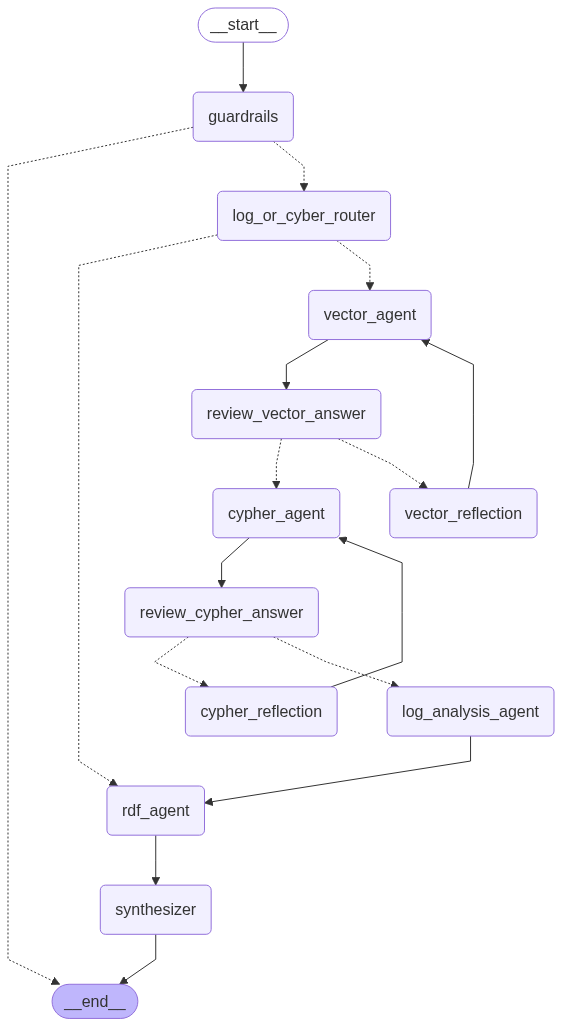

In [192]:
#cell code 20

# --- Visualize the Graph ---
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not create graph visualization: {e}")

In [193]:
query2 = "Give me information about daryl's activity?"

initial_state = {
    "question": query2,
    "original_question": query2,
    "messages": [("human", query2)],
    "cypher_iteration_count": 1,
    "vector_iteration_count": 1,
    "max_iterations": 3,
}

config = {"recursion_limit": 30}
final_result = app.invoke(initial_state, config=config)

2025-07-30 18:46:48,813 - __main__ - INFO - --- Executing Node: [[Guardrails]] ---
2025-07-30 18:46:49,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-30 18:46:49,836 - __main__ - INFO - [[Guardrails]]: Question is relevant.
2025-07-30 18:46:49,837 - __main__ - INFO - [Decision] Question is relevant, proceeding to search.
2025-07-30 18:46:49,839 - __main__ - INFO - --- Executing Node: [[Router]] ---
2025-07-30 18:46:51,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-30 18:46:51,239 - __main__ - INFO - [[Router]]: Routing decision: log_analysis
2025-07-30 18:46:51,240 - __main__ - INFO - [Decision] Question is about logs, proceeding to vector search.
2025-07-30 18:46:51,242 - __main__ - INFO - --- Executing Node: [[vector_agent]] ---


--- Executing Vector Search for: Give me information about daryl's activity? ---


2025-07-30 18:46:52,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



--- Extracted Entities: ['daryl'] ---


d:\Project\multi-agents-rag-cykg\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
2025-07-30 18:46:53,503 - __main__ - INFO - [[Vector Agent]] : Vector search completed successfully.
2025-07-30 18:46:53,504 - __main__ - INFO - [[Vector Agent]] : Vector search context found:
Structured data:
    Entity 'daryl' found in document 'mail.cup.com.auth.txt'. The context of the text is: '_unix(cron:session): session closed for user root Feb 29 15:22:55 mail-0 auth: pam_unix(dovecot:auth): authentication failure; logname= uid=0 euid=0 tty=dovecot ruser=danette rhost=127.0.0.1  user=danette Feb 29 15:23:04 mail-0 auth: pam_unix(dovecot...'
Entity 'daryl' found in document 'mail.cup.com.auth.txt'. The context of the text is: 'uid=0 tty=dovecot ruser=daryl rhost=127.0.0.1  user=daryl Feb 29 15:38:42 mail-0 auth: pam_unix(dov

--- Executing Cypher Search for: Give me information about daryl's activity? ---


> Entering new GraphCypherQAChain chain...


2025-07-30 18:46:57,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated Cypher:
MATCH (u:User)-[r]->(n)
WHERE toLower(u.id) = 'daryl'
RETURN u.id AS user, type(r) AS relationship, n.id AS entity
Full Context:
[{'user': 'daryl', 'relationship': 'AUTHENTICATION_FAILURE_ON', 'entity': 'mail-0'}, {'user': 'daryl', 'relationship': 'AUTHENTICATED_ON', 'entity': 'mail-0'}]


2025-07-30 18:46:58,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-30 18:46:58,834 - __main__ - INFO - [[Cypher Agent]]: Found context. Query: MATCH (u:User)-[r]->(n)
WHERE toLower(u.id) = 'daryl'
RETURN u.id AS user, type(r) AS relationship, n.id AS entity
2025-07-30 18:46:58,836 - __main__ - INFO - --- Executing Node: [[review_cypher_answer]] ---
2025-07-30 18:46:58,836 - __main__ - INFO - [[Review Cypher]]: Found new context, saving as 'latest_cypher_context'.



> Finished chain.


2025-07-30 18:47:00,450 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-30 18:47:00,457 - __main__ - INFO - [[Review Cypher]]: Decision: sufficient. Reasoning: The context provides factual information about Daryl's activity, specifically related to authentication events on 'mail-0'. It mentions both an authentication failure and a successful authentication, which are concrete data points relevant to understanding Daryl's activity.
2025-07-30 18:47:00,458 - __main__ - INFO - [Decision] Cypher context is sufficient. Proceeding to Log Analysis agent.
2025-07-30 18:47:00,460 - __main__ - INFO - --- Executing Node: [[Log Analysis Agent]] ---
2025-07-30 18:47:02,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-30 18:47:02,850 - __main__ - INFO - [[Log Analysis Agent]]: Log Summary: The logs indicate that Daryl experienced an authentication failure on the mail-0 server at 15:38

In [194]:
#print the result
print(final_result.get('answer'))

---
**1. Original Question:**
Give me information about daryl's activity?

**2. Cypher Log Information Context:**
[{'user': 'daryl', 'relationship': 'AUTHENTICATION_FAILURE_ON', 'entity': 'mail-0'}, {'user': 'daryl', 'relationship': 'AUTHENTICATED_ON', 'entity': 'mail-0'}]

**3. Vector Log Information Context:**
Structured data:
    Entity 'daryl' found in document 'mail.cup.com.auth.txt'. The context of the text is: '_unix(cron:session): session closed for user root Feb 29 15:22:55 mail-0 auth: pam_unix(dovecot:auth): authentication failure; logname= uid=0 euid=0 tty=dovecot ruser=danette rhost=127.0.0.1  user=danette Feb 29 15:23:04 mail-0 auth: pam_unix(dovecot...'
Entity 'daryl' found in document 'mail.cup.com.auth.txt'. The context of the text is: 'uid=0 tty=dovecot ruser=daryl rhost=127.0.0.1  user=daryl Feb 29 15:38:42 mail-0 auth: pam_unix(dovecot:auth): authentication failure; logname= uid=0 euid=0 tty=dovecot ruser=daryl rhost=127.0.0.1  user=daryl Feb 29 15:39:01 mail-0 CRON

In [171]:
# #cell code 18

# # --- Invocation ---
# query1 = "Which MITRE ATT&CK techniques are used by attackers to escalate their privileges within a network?"
# query2 = "find me a list of mitigation actions for attack technique Credential Access"

# # Irrelevant question for Guardrails example
# query3 = "What is the best recipe for fried chicken?"

# initial_state = {
#     "question": query2,
#     "original_question": query2,
#     "messages": [("human", query2)],
#     "cypher_iteration_count": 1,
#     "vector_iteration_count": 1,
#     "max_iterations": 3,
# }

# config = {"recursion_limit": 30}
# final_result = app.invoke(initial_state, config=config)
